In [1]:
import matplotlib.pyplot as plt
import itertools
import phyre
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from glob import glob
import math
import random
import numpy as np
import re
import sys
import os

if '../..' not in sys.path:
    sys.path.append('../..')

from data import ClassicalMechanicsDataset

In [2]:
class OneBallFreeFallPredictionFromInitialState(ClassicalMechanicsDataset):
    def __getitem__(self, idx):
        data = np.load(self.data_files[idx])
        return torch.FloatTensor(data[0]).unsqueeze(dim=0), torch.FloatTensor(data[1:]).reshape(1,-1)


    def generate_data(self):
        # Choosing a setup where only one ball is needed
        eval_setup = 'ball_cross_template'

        # We only need one fold as we mix all the data together anyway
        fold_id = 0

        train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, fold_id)
        tasks = list(train_tasks + dev_tasks + test_tasks)
        
        # Filtering tasks to only include a simple two-ball template. The template key: '00000:xxx'
        task_filter = re.compile("00000:*")
        tasks = list(filter(task_filter.match, tasks))
        
        # Choosing a single scenario in which we will generate our free-falls
        tasks = [tasks[0]]

        # Getting action tier for our tasks - a single ball
        action_tier = phyre.eval_setup_to_action_tier(eval_setup)

        # Create the simulator from the tasks and tier.
        simulator = phyre.initialize_simulator(tasks, action_tier)

        # getting a 10000 actions from a simulator
        # it uniformly samples actions skipping invalid ones
        # Action dimensions: 3 (x, y, radius) - represent coordinates and size of the red ball
        actions = simulator.build_discrete_action_space(max_actions=10000)
        
        # Defining a function to check if the red ball is in the free fall throughout the simulation
        def is_red_ball_in_free_fall(simulation):
            features = simulation.featurized_objects.features
            return False not in [features[0][-1][0] == features[frame_id][-1][0] for frame_id in range(len(features))]

        # Getting only the coordinates of the red ball
        def get_red_ball_data(simulation):
            features = simulation.featurized_objects.features
            data = []
            # I am only interested in saving the first 25 frames if the simulation is larger
            for frame_id in range(min(25, len(features))):
                data.append([features[frame_id][-1][1]])
            return data
        
        if not os.path.exists(self.data_path):
            os.makedirs(self.data_path)
        else:
            import glob
            files = glob.glob(self.data_path + '/*')
            for file in files:
                os.remove(file)
        
        # we are using a single task
        task_index = 0

        for action_index in range(len(actions)):
            simulation = simulator.simulate_action(task_index, actions[action_index], need_images=True, need_featurized_objects=True, stride=15)
            if simulation.status.is_invalid(): continue
            if is_red_ball_in_free_fall(simulation):
                np.save(self.data_path + f'/action-{action_index}', get_red_ball_data(simulation))

In [26]:
batch_size = 1

train_data, test_data = OneBallFreeFallPredictionFromInitialState.train_test_split('../../data/raw/single-ball-free-fall-initial', test_frac=0.2, random_state=42)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  1072
train_test_split response: test fraction rounded to 0.19996269352732698 (1072 simulations)


# Neural Networks for Predicting from Initial State

In [4]:
class LinearModelFor1DFreeFallPredictionFromInitialState_3Layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_1=nn.Linear(input_dim, 64)
        self.hidden_2=nn.Linear(64,32)
        self.output=torch.nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = F.relu(self.output(x))

        return x

In [5]:
for X, y in train_dataloader:
    print(X)
    print(y)
    break

tensor([[[0.7148]]])
tensor([[[0.7062, 0.6832, 0.6459, 0.5942, 0.5282, 0.4478, 0.3530, 0.2439,
          0.1205, 0.0127, 0.0316, 0.0362, 0.0265, 0.0088, 0.0079, 0.0079,
          0.0079, 0.0079, 0.0079, 0.0079, 0.0079, 0.0079, 0.0079, 0.0079]]])


In [6]:
model1 = LinearModelFor1DFreeFallPredictionFromInitialState_3Layer(1, 24)
print(model1)

learning_rate = 0.1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)


# Training the model on 100 epochs
num_epochs = 100

# This array will store the loss values per epoch
loss_per_epoch = []

# This variable is needed to calculate the total epoch loss
epoch_loss = 0

# Training
epoch = 0
while epoch < num_epochs:
    for X, y in train_dataloader:
        # For each data instance we need to reset the optimizer gradients
        optimizer.zero_grad()
        
        pred = model1(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    if epoch == 0 and epoch_loss >= 15:
        print('Unsuccessfull loss: ', epoch_loss)
        epoch_loss = 0
        model1 = LinearModelFor1DFreeFallPredictionFromInitialState_3Layer(1, 24)
        optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)
        continue
        
        
    loss_per_epoch.append(epoch_loss)
    
    # Keeping training log
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    
    epoch_loss = 0
    epoch += 1

LinearModelFor1DFreeFallPredictionFromInitialState_3Layer(
  (hidden_1): Linear(in_features=1, out_features=64, bias=True)
  (hidden_2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=24, bias=True)
)
Unsuccessfull loss:  133.26638940701378
Unsuccessfull loss:  51.22268050099956
Unsuccessfull loss:  158.54343890974997
Unsuccessfull loss:  83.97485205292469
Unsuccessfull loss:  33.77345801022602
Unsuccessfull loss:  116.38567971199518
Unsuccessfull loss:  68.14123547961935
Unsuccessfull loss:  126.14003771790885
Unsuccessfull loss:  97.43248222160037
Unsuccessfull loss:  44.692751255759504
Unsuccessfull loss:  26.664101930131437
Unsuccessfull loss:  113.51262216252508
Unsuccessfull loss:  65.05488572997274
Unsuccessfull loss:  103.85140619770391
Unsuccessfull loss:  150.68679770687595
Unsuccessfull loss:  126.54938718432095
Unsuccessfull loss:  67.50673699539038
Unsuccessfull loss:  78.9928810413403
Unsuccessfull loss:  124.35181939462

In [8]:
for X, y in test_dataloader:
    print(X.squeeze().numpy())
    print(y.reshape(1,-1)[0].numpy())
    break

0.36321747
[0.35460418 0.33163542 0.2943112  0.24263151 0.1765964  0.09620583
 0.04975281 0.05549498 0.04688168 0.04302418 0.04308377 0.04308579
 0.04308579 0.04308579 0.04308579 0.04308579 0.04308579 0.04308579
 0.04308579 0.04308579 0.04308579 0.04308579 0.04308579 0.04308579]


Test loss:  tensor(0.0468, grad_fn=<PowBackward0>)


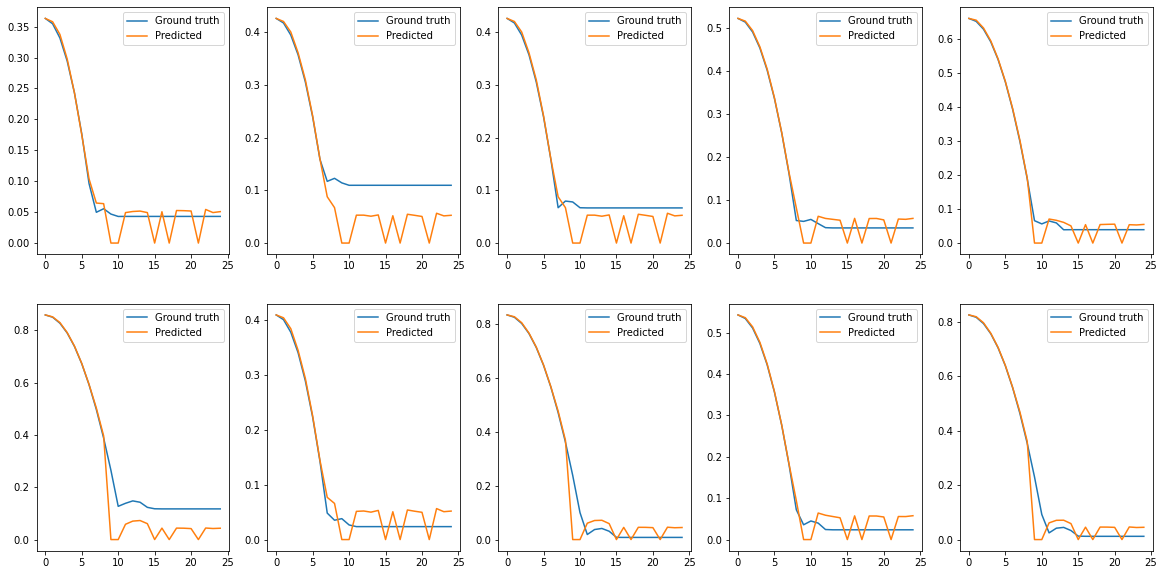

In [27]:
test_loss = (np.sum([loss_fn(model1(X), y) for X, y in test_dataloader]) / len(test_data))**0.5
print('Test loss: ', test_loss)

count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))
    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model1(X)
        axs[int(count >= 5)][count % 5].plot(np.insert(y.reshape(1,-1)[0].numpy(), 0, X.squeeze().numpy()), label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(np.insert(pred.reshape(1,-1)[0].numpy(), 0, X.squeeze().numpy()), label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1

In [10]:
class LinearModelFor1DFreeFallPredictionFromInitialState_5Layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_1=nn.Linear(input_dim, 256)
    #    nn.init.kaiming_uniform_(self.hidden_1.weight, nonlinearity='relu')
        self.hidden_2=nn.Linear(256,128)
     #   nn.init.kaiming_uniform_(self.hidden_2.weight, nonlinearity='relu')
        self.hidden_3=nn.Linear(128,64)
      #  nn.init.kaiming_uniform_(self.hidden_3.weight, nonlinearity='relu')
        self.hidden_4=nn.Linear(64,32)
       # nn.init.kaiming_uniform_(self.hidden_4.weight, nonlinearity='relu')
        self.output=torch.nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = F.relu(self.hidden_3(x))
        x = F.relu(self.hidden_4(x))
        x = F.relu(self.output(x))

        return x

In [11]:
model2 = LinearModelFor1DFreeFallPredictionFromInitialState_5Layer(1, 24)
print(model2)

learning_rate = 0.1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)


# Training the model on 100 epochs
num_epochs = 100

# This array will store the loss values per epoch
loss_per_epoch = []

# This variable is needed to calculate the total epoch loss
epoch_loss = 0

# Training
epoch = 0
while epoch < num_epochs:
    for X, y in train_dataloader:
        # For each data instance we need to reset the optimizer gradients
        optimizer.zero_grad()
        
        pred = model2(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    if epoch == 0 and epoch_loss >= 20:
        print('Unsuccessfull loss: ', epoch_loss)
        epoch_loss = 0
        model2 = LinearModelFor1DFreeFallPredictionFromInitialState_5Layer(1, 24)
        optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)
        continue
        
    loss_per_epoch.append(epoch_loss)
    
    # Keeping training log
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    
    epoch_loss = 0
    epoch += 1

LinearModelFor1DFreeFallPredictionFromInitialState_5Layer(
  (hidden_1): Linear(in_features=1, out_features=256, bias=True)
  (hidden_2): Linear(in_features=256, out_features=128, bias=True)
  (hidden_3): Linear(in_features=128, out_features=64, bias=True)
  (hidden_4): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=24, bias=True)
)
Unsuccessfull loss:  194.24677478554077
Unsuccessfull loss:  86.00437416590285
Unsuccessfull loss:  220.72872364832438
Unsuccessfull loss:  63.70233560880297
Unsuccessfull loss:  73.00249157322105
Unsuccessfull loss:  55.702712744590826
Unsuccessfull loss:  63.81714946680586
Unsuccessfull loss:  173.18254084564978
Unsuccessfull loss:  121.58702653786168
Unsuccessfull loss:  105.32259776833234
Unsuccessfull loss:  56.57905249969917
Unsuccessfull loss:  189.7813195619674
Unsuccessfull loss:  226.66392747085774
Unsuccessfull loss:  136.536679090932
Epoch 0 complete. Training loss: 13.008468930987874
Epoch 1 c

Test loss:  tensor(0.0359, grad_fn=<PowBackward0>)


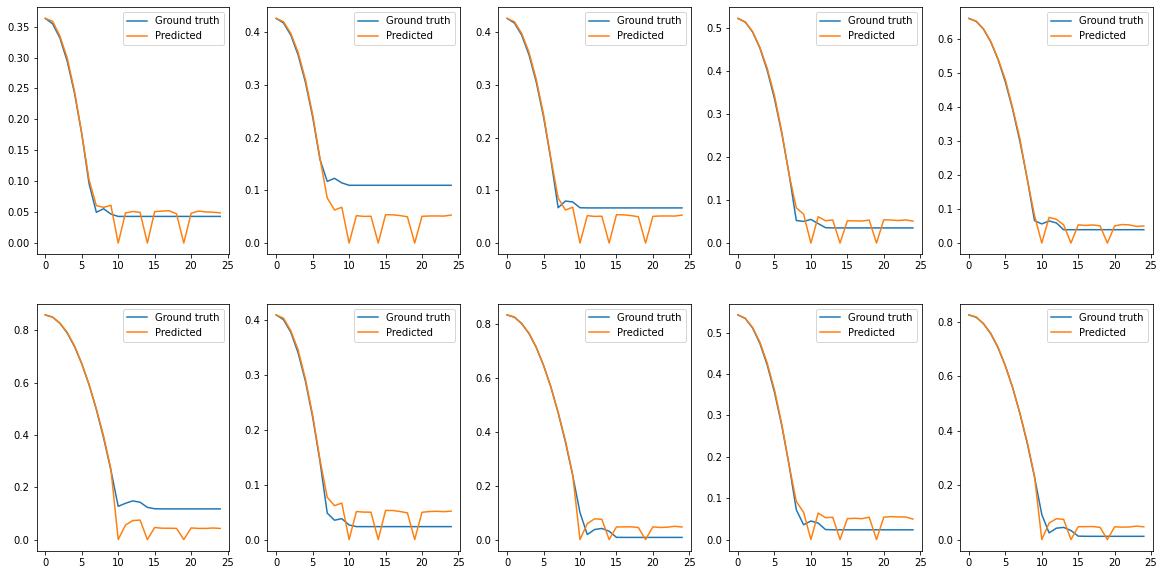

In [28]:
test_loss = (np.sum([loss_fn(model2(X), y) for X, y in test_dataloader]) / len(test_data))**0.5
print('Test loss: ', test_loss)

count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))
    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model2(X)
        axs[int(count >= 5)][count % 5].plot(np.insert(y.reshape(1,-1)[0].numpy(), 0, X.squeeze().numpy()), label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(np.insert(pred.reshape(1,-1)[0].numpy(), 0, X.squeeze().numpy()), label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1

# Including the diameter into the data

In [13]:
from data import OneBallFreeFallPredictionFromInitialStateWithDiameterDataset

In [14]:
batch_size = 1

train_data, test_data = OneBallFreeFallPredictionFromInitialStateWithDiameterDataset.train_test_split('../../data/raw/single-ball-free-fall-initial-with-diameter/', test_frac=0.2, random_state=42)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  1072
train_test_split response: test fraction rounded to 0.19996269352732698 (1072 simulations)


In [15]:
for X, y in train_dataloader:
    print(X)
    print(y)
    break

tensor([[[0.7148, 0.0156]]])
tensor([[[0.7062, 0.6832, 0.6459, 0.5942, 0.5282, 0.4478, 0.3530, 0.2439,
          0.1205, 0.0127, 0.0316, 0.0362, 0.0265, 0.0088, 0.0079, 0.0079,
          0.0079, 0.0079, 0.0079, 0.0079, 0.0079, 0.0079, 0.0079, 0.0079]]])


In [16]:
class LinearModelFor1DFreeFallPredictionFromInitialState_5Layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_1=nn.Linear(input_dim, 256)
        self.hidden_2=nn.Linear(256,128)
        self.hidden_3=nn.Linear(128,64)
        self.hidden_4=nn.Linear(64,32)
        self.output=torch.nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = F.relu(self.hidden_3(x))
        x = F.relu(self.hidden_4(x))
        x = F.relu(self.output(x))

        return x

In [17]:
model = LinearModelFor1DFreeFallPredictionFromInitialState_5Layer(2, 24)
print(model)

learning_rate = 0.1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# Training the model on 100 epochs
num_epochs = 100

# This array will store the loss values per epoch
loss_per_epoch = []

# This variable is needed to calculate the total epoch loss
epoch_loss = 0

# Training
epoch = 0
while epoch < num_epochs:
    for X, y in train_dataloader:
        # For each data instance we need to reset the optimizer gradients
        optimizer.zero_grad()
        
        pred = model(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    if epoch == 0 and epoch_loss >= 20:
        print('Unsuccessfull loss: ', epoch_loss)
        epoch_loss = 0
        model = LinearModelFor1DFreeFallPredictionFromInitialState_5Layer(2, 24)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        continue
        
        
    loss_per_epoch.append(epoch_loss)
    
    # Keeping training log
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    
    epoch_loss = 0
    epoch += 1

LinearModelFor1DFreeFallPredictionFromInitialState_5Layer(
  (hidden_1): Linear(in_features=2, out_features=256, bias=True)
  (hidden_2): Linear(in_features=256, out_features=128, bias=True)
  (hidden_3): Linear(in_features=128, out_features=64, bias=True)
  (hidden_4): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=24, bias=True)
)
Unsuccessfull loss:  93.42029689723859
Unsuccessfull loss:  131.34056713205064
Unsuccessfull loss:  118.26275787799386
Unsuccessfull loss:  124.16604751482373
Unsuccessfull loss:  113.98698519618483
Unsuccessfull loss:  84.20123040152248
Unsuccessfull loss:  66.05228817404713
Unsuccessfull loss:  128.01805306837196
Unsuccessfull loss:  226.84448477439582
Unsuccessfull loss:  111.66741885262309
Unsuccessfull loss:  133.11058255372336
Unsuccessfull loss:  115.49000072851777
Unsuccessfull loss:  183.73664768307935
Unsuccessfull loss:  125.2585542369925
Unsuccessfull loss:  160.24004677706398
Unsuccessfull los

Test loss:  tensor(0.0226, grad_fn=<PowBackward0>)


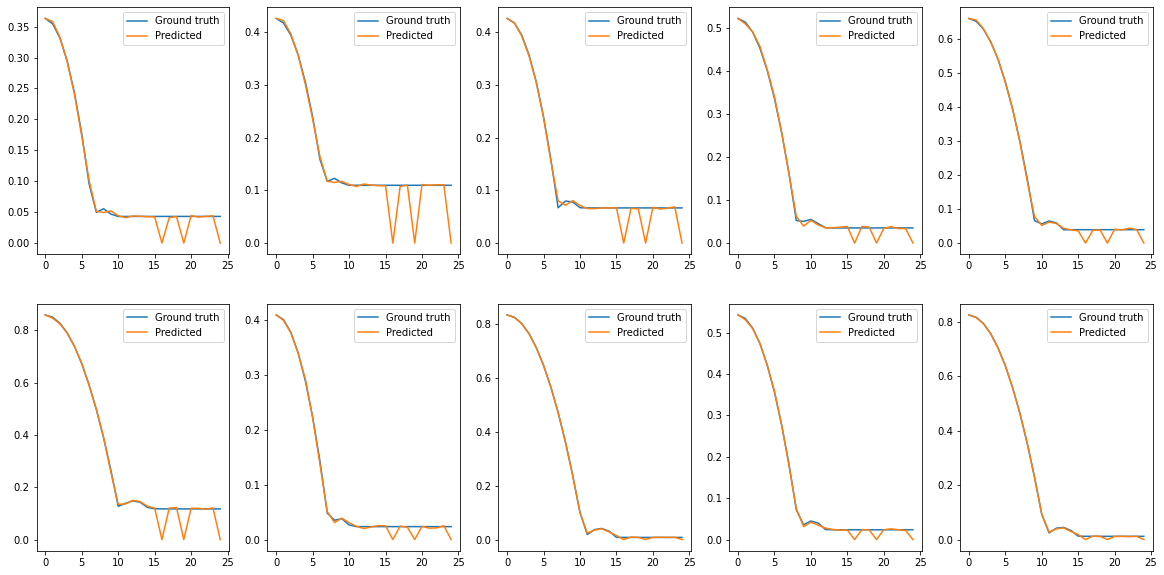

In [25]:
test_loss = (np.sum([loss_fn(model(X), y) for X, y in test_dataloader]) / len(test_data))**0.5
print('Test loss: ', test_loss)

count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))
    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model(X)
        axs[int(count >= 5)][count % 5].plot(np.insert(y.reshape(1,-1)[0].numpy(), 0, X.squeeze().numpy()[0]), label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(np.insert(pred.reshape(1,-1)[0].numpy(), 0, X.squeeze().numpy()[0]), label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1